<a href="https://colab.research.google.com/github/jiinpark21/ESAA_24-2/blob/main/11%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_1111_%EC%BC%80%EB%9D%BC%EC%8A%A4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 딥러닝 텐서플로 ch3. 4, 6~7

p.87-95, 105-115

# [Chapter 3] 케라스(Keras)

# 4.모델 세부 설정

In [1]:
import tensorflow as tf

# 케라스의 내장 데이터셋이서 mnist 데이터셋 로드
mnist = tf.keras.datasets.mnist

# load_data()로 데이터셋 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 로드된 데이터셋 확인
print('train set: ', x_train.shape, y_train.shape)
print('test set: ', x_test.shape, y_test.shape)

# 데이터 정규화
x_train = x_train / x_train.max() # max: 255
x_test = x_test / x_test.max() # max: 255

train set:  (60000, 28, 28) (60000,)
test set:  (10000, 28, 28) (10000,)


## 4-1. 초기값 설정

- Dense 레이어 : 기본 초기화 방법으로 'Gloror Uniform' 초기화 방법 설정

- 자주 사용되는 초기화 목록
  - 'glorot_normal', 'glorot_uniform' : 글로럿 초기화(Xavier 초기화)
  - 'lecun_normal', 'lecun_uniform' : Yann Lecun 초기화
  - 'he_normal', 'he_uniform' : He 초기화
  - 'random_normal', 'random_uniform' : 정규 분포, 연속균등 분포 초기화

In [2]:
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()['kernel_initializer']

{'module': 'keras.initializers',
 'class_name': 'GlorotUniform',
 'config': {'seed': None},
 'registered_name': None}

In [3]:
# 문자열 초기화
dense = tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='relu')
print(dense.get_config()['kernel_initializer'])

# 클래스 인스턴스 초기화
he_normal = tf.keras.initializers.he_normal()
dense = tf.keras.layers.Dense(256, kernel_initializer=he_normal, activation='relu')
print(dense.get_config()['kernel_initializer'])

{'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}
{'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}


## 4-2. 규제

- 모델의 과대적합 해소하기 위해 L1, L2 규제 사용
- 텐서플로 케라스 레이어 : 기본값으로 규제 적용 x -> 규제 적용 위해서는 별도 설정 필요

In [4]:
# 기본 값
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()

{'name': 'dense_3',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'units': 256,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'GlorotUniform',
  'config': {'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [5]:
# l1 규제 적용
dense = tf.keras.layers.Dense(256, kernel_regularizer='l1', activation='relu')
print(dense.get_config()['kernel_regularizer'])

# 클래스 인스턴스 적용, alpha=0.1 변경
regularizer = tf.keras.regularizers.l1(l1=0.1)
dense = tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu')
print(dense.get_config()['kernel_regularizer'])

{'module': 'keras.regularizers', 'class_name': 'L1', 'config': {'l1': 0.009999999776482582}, 'registered_name': None}
{'module': 'keras.regularizers', 'class_name': 'L1', 'config': {'l1': 0.10000000149011612}, 'registered_name': None}


## 4-3. 드랍아웃

- 드롭아웃 : 모델의 과대적합 문제를 해결하기 위해 제안된 아이디어
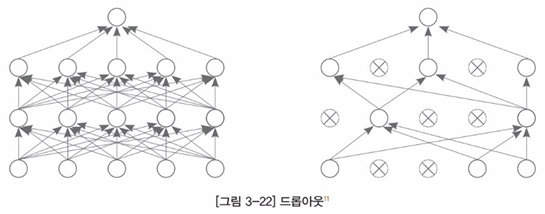

- 오른쪽 그림 - 모든 노드가 연결되어 있지 않고 확률적으로 몇 개의 신호가 끊겨 있음
  - 노드의 일부 신호를 임의로 삭제하면, 모델이 쉽게 과대적합 되는 것을 방지 가능
  - 모델이 학습하는 가중치 파라미터의 개수가 현저하게 줄어들기 때문
  - 훈련에는 드롭아웃이 적용되어 노드 중 일부만 훈련하지만, 예측 시에는 모든 노드들이 활용됨

In [6]:
# Dropout 25% 비율 적용 (25%의 노드가 삭제)
tf.keras.layers.Dropout(0.25)

<Dropout name=dropout, built=False>

## 4-4. 배치 정규화

- 배치 정규화 : 각 층에서 활성화 함수를 통과하기 전 미니 배치의 스케일 정규화
  - 다음 층으로 데이터 전달되기 전에 스케일 조정 -> 보다 안정적인 훈련, 성능 크게 향상
  - 클래스 인스턴스 생성하여 추가

- model_a : Dense 레이어에 ReLU 활성화 함수 추가한 모델

In [7]:
# Model A: Dense + ReLU
model_a = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model_a.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,650 (205.66 KB)

 Trainable params: 52,650 (205.66 KB)

 Non-trainable params: 0 (0.00 B)

- model_b : 배치 정규화 적용 후 ReLU 활성화 함수 추가한 모델

In [8]:
# Model B: Dense + BatchNorm + ReLU
model_b = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64),
    # 배치정규화 적용
    tf.keras.layers.BatchNormalization(),
    # 배치정규화 후 활성화 함수 적용
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(32),
    # 배치정규화 적용
    tf.keras.layers.BatchNormalization(),
    # 배치정규화 후 활성화 함수 적용
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(10, activation='softmax'),
])
model_b.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,034 (207.16 KB)

 Trainable params: 52,842 (206.41 KB)

 Non-trainable params: 192 (768.00 B)

- 배치 정규화 추가 시 : 손실이 더 안정적이고 빠르게 수렴

## 4-5. 활성화 함수

In [9]:
# LeakyReLU 기본 설정
tf.keras.layers.LeakyReLU()

# LeakyReLU, alpha=0.2 로 변경
tf.keras.layers.LeakyReLU(alpha=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


<LeakyReLU name=leaky_re_lu_1, built=False>

- model_c : Dense 레이어 + 배치 정규화 + LeakyReLU(0.2) 활성화 함수

In [10]:
# Model C: Dense + BatchNorm + LeakyReLU(0.2)
model_c = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64),
    # 배치정규화 적용
    tf.keras.layers.BatchNormalization(),
    # LeakyReLU, alpha=0.2 적용
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Dense(32),
    # 배치정규화 적용
    tf.keras.layers.BatchNormalization(),
    # LeakyReLU, alpha=0.2 적용
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Dense(10, activation='softmax'),
])

# 모델 요약
model_c.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,034 (207.16 KB)

 Trainable params: 52,842 (206.41 KB)

 Non-trainable params: 192 (768.00 B)

- model_a, model_b, model_c를 동일 조건에서 10번의 epoch 동안 훈련 후, 수렴 속도 확인

In [14]:
model_a.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_c.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model A: Dense + ReLU
history_a = model_a.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        epochs=10)

# Model B: Dense + BatchNorm + ReLU
history_b = model_b.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        epochs=10)

# Model C: Dense + BatchNorm + LeakyReLU(0.2)
history_c = model_c.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8400 - loss: 0.5406 - val_accuracy: 0.9545 - val_loss: 0.1510
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9581 - loss: 0.1407 - val_accuracy: 0.9639 - val_loss: 0.1190
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9701 - loss: 0.0985 - val_accuracy: 0.9633 - val_loss: 0.1159
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9767 - loss: 0.0762 - val_accuracy: 0.9668 - val_loss: 0.1050
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9813 - loss: 0.0607 - val_accuracy: 0.9741 - val_loss: 0.0882
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9833 - loss: 0.0522 - val_accuracy: 0.9718 - val_loss: 0.0967
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9854 - loss: 0.0431 - val_accuracy: 0.9703 - val_loss: 0.0957
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9883 - loss: 0.0390 - 

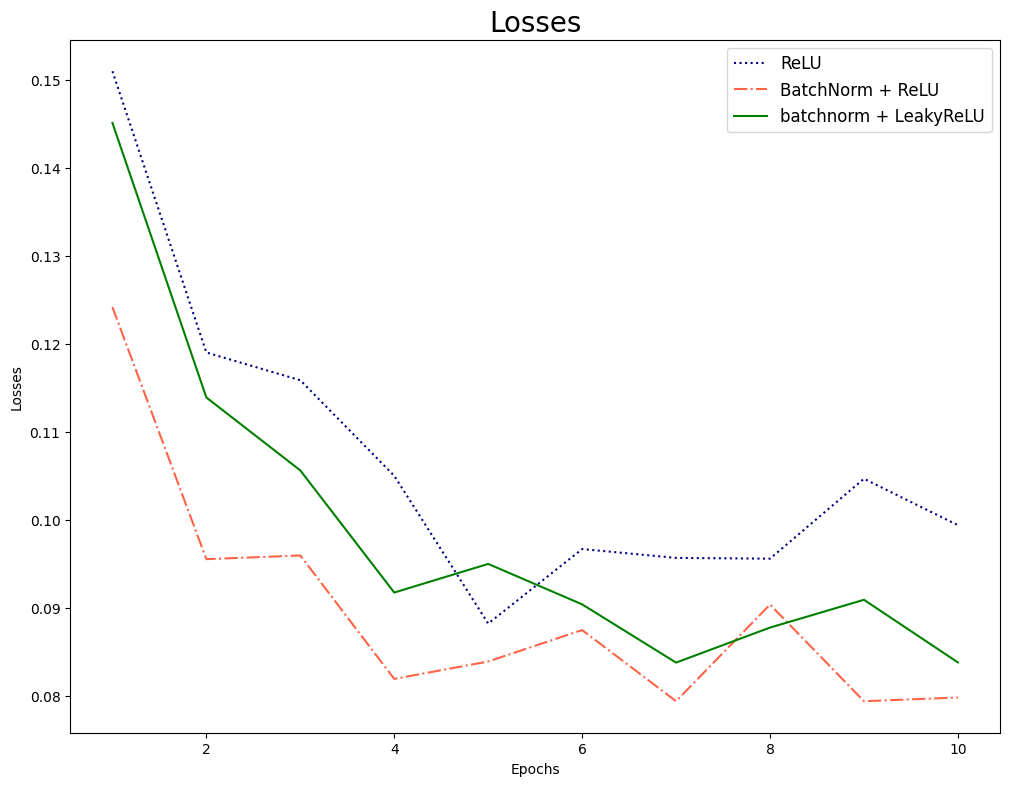

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, 11), history_a.history['val_loss'], color='navy', linestyle=':')
plt.plot(np.arange(1, 11), history_b.history['val_loss'], color='tomato', linestyle='-.')
plt.plot(np.arange(1, 11), history_c.history['val_loss'], color='green', linestyle='-')

plt.title('Losses', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['ReLU', 'BatchNorm + ReLU','batchnorm + LeakyReLU'], fontsize=12)
plt.show()

- mnist 데이터셋에서는 모델별로 크게 차이나지 x

# 6.모델 저장 및 불러오기

In [16]:
import tensorflow as tf

# 케라스의 내장 데이터셋에서 mnist 데이터셋을 로드
mnist = tf.keras.datasets.mnist

# load_data()로 데이터셋을 로드 합니다.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 정규화
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'), # 노드는 10개가 되어야 한다.
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train,
            validation_data=(x_test, y_test),
            epochs=10,
            )

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8808 - loss: 0.4034 - val_accuracy: 0.9695 - val_loss: 0.0991
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9708 - loss: 0.0957 - val_accuracy: 0.9715 - val_loss: 0.0929
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9808 - loss: 0.0613 - val_accuracy: 0.9769 - val_loss: 0.0739
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9853 - loss: 0.0459 - val_accuracy: 0.9780 - val_loss: 0.0748
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9888 - loss: 0.0346 - val_accuracy: 0.9757 - val_loss: 0.0888
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9898 - loss: 0.0310 - val_accuracy: 0.9772 - val_loss: 0.0873
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9921 - loss: 0.0244 - val_accuracy: 0.9794 - val_loss: 0.0804
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9934 - loss: 0.

## 6-1. 모델을 파일로 저장

- save() : 훈련이 종료되어 가중치가 업데이트된 모델 인스턴스 저장 가능
  - HDF5(Hierarchical Data Format) 포맷 : '.h5' 확장자 포함, 대용량의 데이터 저장

In [18]:
# 모델을 h5 포맷으로 저장
model.save('h5-model.h5')

## 6-2. 저장된 모델을 복원

- load_model() : 저장된 모델 복원 가능
- summary()를 통해 모델 구조가 그대로 복원된 것을 확인할 수 있음

In [19]:
# 모델 복원
h5_model = tf.keras.models.load_model('h5-model.h5')
h5_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 219,820 (858.68 KB)

 Trainable params: 219,818 (858.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [20]:
# 모델 검증
loss, acc = h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5 model] loss: {loss:.5f}, acc: {acc:.5f}')

h5 model] loss: 0.08650, acc: 0.97850


In [24]:
# 모델을 SavedModel 포맷으로 저장
model_c.save('saved-model.keras')

In [27]:
# 모델 복원
saved_model = tf.keras.models.load_model('saved-model.keras')
saved_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,720 (620.00 KB)

 Trainable params: 52,842 (206.41 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 105,686 (412.84 KB)

In [28]:
# 모델 검증 (HDF5 포맷)
loss, acc = h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5 model] loss: {loss:.5f}, acc: {acc:.5f}')

# 모델 검증 (SavedModel 포맷)
loss, acc = saved_model.evaluate(x_test, y_test, verbose=0)
print(f'saved_model] loss: {loss:.5f}, acc: {acc:.5f}')

h5 model] loss: 0.08650, acc: 0.97850
saved_model] loss: 0.08382, acc: 0.97530


# 7.복잡한 모델 생성

- 함수 형태로 딥러닝 모델 정의 시, 다양한 모델 구조 구현 가능

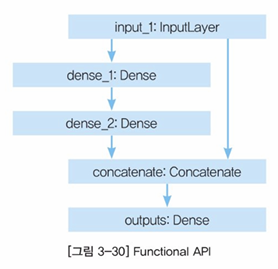

- 여러 층을 시퀀스 형태로 연결하는 Sequential API와 다르게, Functional API는 복잡한 구조의 모델 정의 가능

In [29]:
import tensorflow as tf

# 케라스의 내장 데이터셋에서 mnist 데이터셋을 로드
mnist = tf.keras.datasets.mnist

# load_data()로 데이터셋을 로드 합니다.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 정규화
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

## 7-1. 함수형 API(Functional API)

- 함수형 API 사용하기 위해서 먼저 Input 레이어 정의
  - Input 레이어에 데이터의 입력 Shape 정의
  - 레이어마다 반환되는 출력 값을 변수에 저장한 뒤, 다음 레이어의 입력으로 연결
  - 레이어마다 name 매개변수로 이름 부여 가능

In [31]:
# 모델의 레이어를 체인 구조로 연결 Input 레이어 정의
input_layer = tf.keras.Input(shape=(28, 28), name='InputLayer')

# 모델의 레이어를 체인 구조로 연결
x1 = tf.keras.layers.Flatten(name='Flatten')(input_layer)
x2 = tf.keras.layers.Dense(256, activation='relu', name='Dense1')(x1)
x3 = tf.keras.layers.Dense(64, activation='relu', name='Dense2')(x2)
x4 = tf.keras.layers.Dense(10, activation='softmax', name='OutputLayer')(x3)

In [32]:
# 모델 생성
func_model = tf.keras.Model(inputs=input_layer, outputs=x4, name='FunctionalModel')

# 모델 요약
func_model.summary()

Model: "FunctionalModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)              │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense1 (Dense)                       │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense2 (Dense)                       │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OutputLayer (Dense)                  │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,058 (851.79 KB)

 Trainable params: 218,058 (851.79 KB)

 Non-trainable params: 0 (0.00 B)

- plot_model 모듈 : 모델의 구조도 시각화 가능
  - show_shapes = True : 데이터의 입출력 shape 출력
  - show_layer_names = True : 레이어 이름 출력

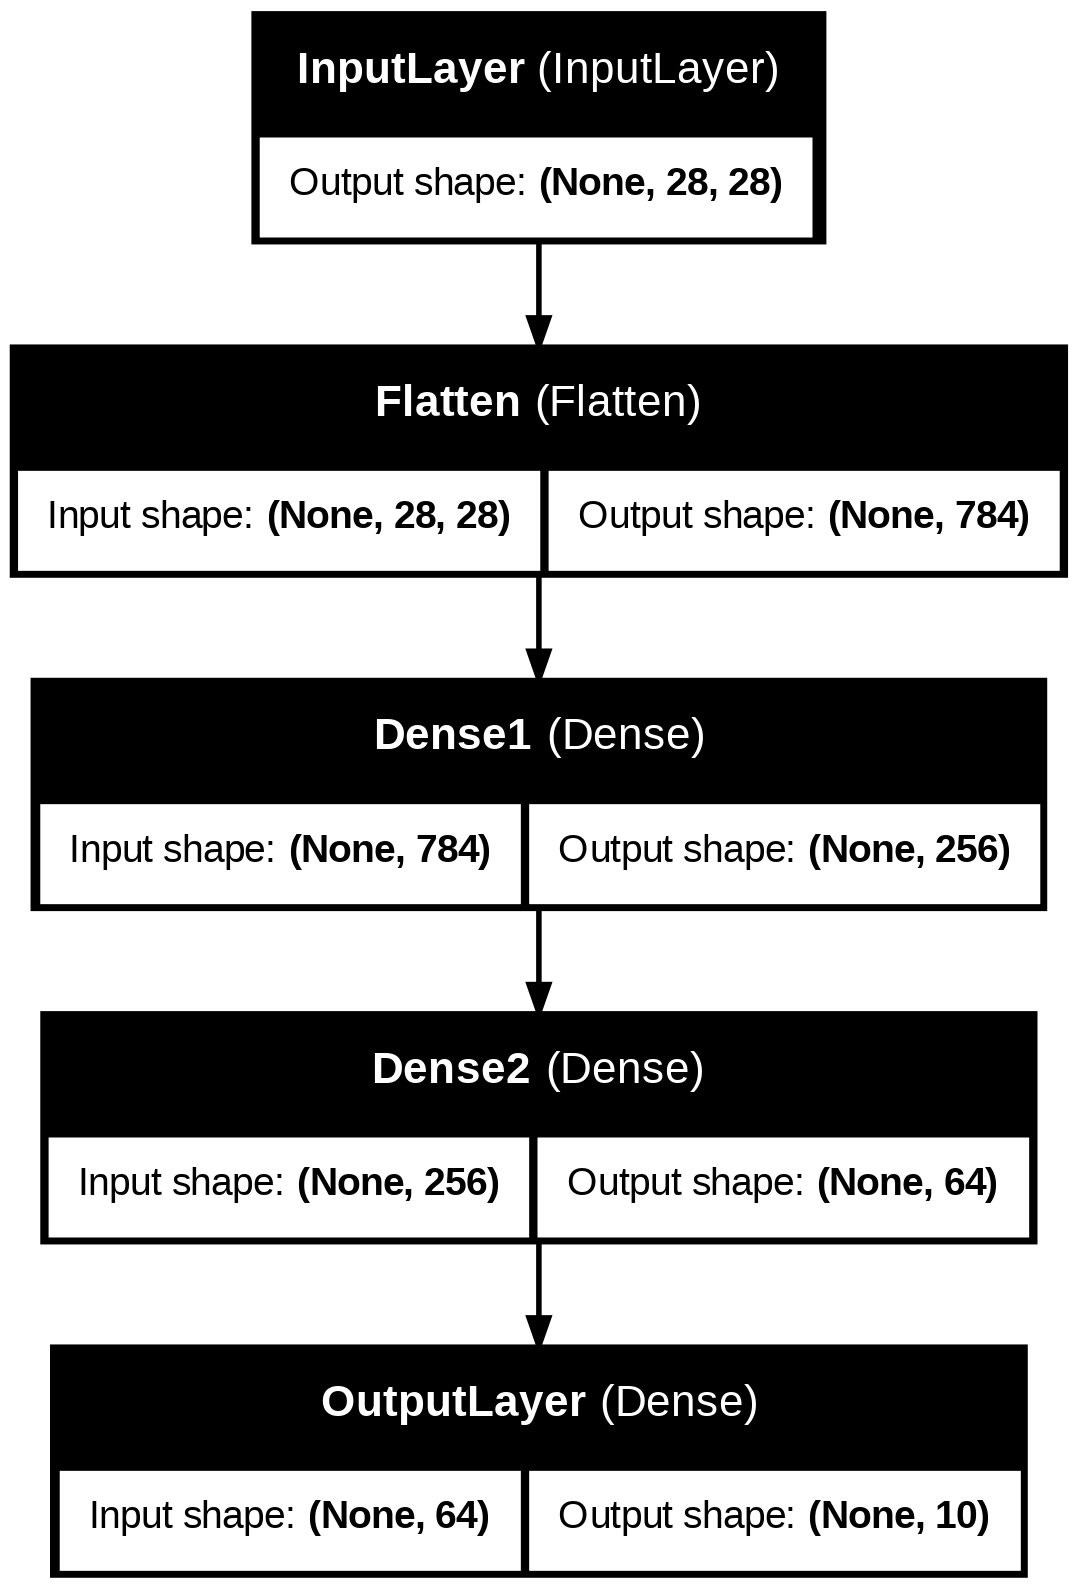

In [33]:
from tensorflow.keras.utils import plot_model

# 구조도 시각화
plot_model(func_model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [34]:
# 컴파일
func_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련
func_model.fit(x_train, y_train, epochs=3)

# 검증
loss, acc = func_model.evaluate(x_test, y_test, verbose=0)
print(f'Functional Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8918 - loss: 0.3758
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9721 - loss: 0.0905
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9820 - loss: 0.0567
Functional Model] loss: 0.07693, acc: 0.97620


## 7-2. Model Subsclassing

- Model Subsclassing으로 모델 인스턴스 생성 시, tf.keras.Model을 상속받아 생성하고자 하는 모델 클래스 구현
  - 모델의 __init__() 함수에 레이어 정의, 레이어의 하이퍼파라미터 정의
  - call() 함수를 메소드 오버라이딩으로 구현
  - call() 메소드는 fit() 메소드가 호출되어 훈련하는 경우 호출될 함수

In [35]:
class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        # 초기값 설정
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(10, activation='softmax')

    # class overiding
    # 학습용 함수 정의
    # x는 input
    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

In [36]:
# 모델 생성
mymodel = MyModel()

# 모델의 이름 설정
mymodel._name = 'subclass_model'

# 모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28, 28)))

# 모델 요약
mymodel.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,058 (851.79 KB)

 Trainable params: 218,058 (851.79 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# 컴파일
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련
mymodel.fit(x_train, y_train, epochs=3)

# 검증
loss, acc = mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8908 - loss: 0.3727
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9718 - loss: 0.0929
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9812 - loss: 0.0571
Subclassing Model] loss: 0.07990, acc: 0.97650


## 7-3. 생성자 parameter를 활용한 생성

- Model Subsclassing 장점 : 생성자 파라미터로 모델 내부 레이어의 하이퍼파라미터 지정 가능
- 다음은 모델의 생성자 파라미터 추가하여 동적으로 레이어의 유닛 개수 초기화하는 예제

In [11]:
class MyModel(tf.keras.Model):

    # 생성자 parameter 추가
    def __init__(self, units, num_classes):
        super(MyModel, self).__init__()
        # 초기값 설정
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units, activation='relu')
        self.dense2 = tf.keras.layers.Dense(int(units/4), activation='relu')
        self.dense3 = tf.keras.layers.Dense(num_classes, activation='softmax')

    # class overiding
    # 학습용 함수 정의
    # x는 input
    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

In [12]:
# 모델 생성
mymodel = MyModel(256, 10)

# 모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28, 28)))

# 모델 요약
mymodel.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,058 (851.79 KB)

 Trainable params: 218,058 (851.79 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# 컴파일
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련
mymodel.fit(x_train, y_train, epochs=3)

# 검증
loss, acc = mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model w. parameters] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8844 - loss: 0.3905
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9718 - loss: 0.0904
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9827 - loss: 0.0567
Subclassing Model w. parameters] loss: 0.08435, acc: 0.97500
